In [2]:
%load_ext autoreload
%autoreload 2

In [78]:
import pandas as pd
import data
from IPython.display import HTML
import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

df = data.get_data()

Le but de ce projet est de construire un modèle de prédiction simple afin de me familiariser avec les concepts de base d'intelligence artificielle. 

Le projet va devoir prédire quels clients sont plus susceptibles d'acheter une assurance caravane en fonction des données provenant du CoIL 2000 Challenge. 

In [ ]:
display(myWidgets.VarComparator(df.columns, df).get_widget())

In [81]:
discrete_vars, continuous_vars = data.get_var_by_types(df)
#corr = df.corr(numeric_only=True).loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns='CARAVAN')
corr_continuous = df[continuous_vars].corr().loc[['CARAVAN']].drop(columns=['CARAVAN'])
corr_discrete = df[discrete_vars + ['CARAVAN']].corr(method='spearman').loc[['CARAVAN']].drop(columns=['CARAVAN'])

corr_combined = pd.concat([corr_continuous, corr_discrete], axis=1).sort_values(by='CARAVAN', axis=1, ascending=False)
corr_top = corr_combined.unstack().sort_values(ascending=False) #2d a 1d (A,B)
corr_combined = corr_combined.style.background_gradient(cmap='coolwarm', axis=None).format(precision=4)

display(HTML(corr_combined.to_html()))


,PPERSAUT,APERSAUT,APLEZIER,MINKGEM,PWAPART,MKOOPKLA,PBRAND,PPLEZIER,AWAPART,MHKOOP,MOPLHOOG,MAUT1,MINK4575,ABRAND,ABYSTAND,MRELGE,MINK7512,PBYSTAND,MSKA,MBERHOOG,MZPART,MBERMIDD,PGEZONG,MOPLMIDD,MGEMOMV,MGODPR,AGEZONG,MSKB1,PWAOREG,AWAOREG,AFIETS,MFWEKIND,PFIETS,MBERZELF,AZEILPL,PLEVEN,MGODRK,ALEVEN,AINBOED,AAANHANG,PAANHANG,PZEILPL,AMOTSCO,MAUT2,MFGEKIND,MSKB2,MINK123M,PMOTSCO,PINBOED,MGODOV,MGEMLEEF,AWABEDR,MAANTHUI,PWABEDR,MINK3045,PBESAUT,ABESAUT,APERSONG,PPERSONG,PVRAAUT,AVRAAUT,PTRACTOR,PWERKT,AWERKT,ATRACTOR,AWALAND,PWALAND,MRELSA,MGODGE,PBROM,ABROM,MSKC,MBERARBG,MFALLEEN,MZFONDS,MBERBOER,MBERARBO,MOSTYPE,MRELOV,MSKD,MOSHOOFD,MAUT0,MHHUUR,MINKM30,MOPLLAAG
CARAVAN,0.1510,0.1495,0.1064,0.1002,0.0953,0.0947,0.0945,0.0914,0.0900,0.0799,0.0782,0.0734,0.0699,0.0695,0.0682,0.0682,0.0632,0.0628,0.0600,0.0572,0.0554,0.0410,0.0402,0.0399,0.0355,0.0348,0.0335,0.0309,0.0305,0.0303,0.0289,0.0287,0.0287,0.0266,0.0262,0.0211,0.0196,0.0193,0.0191,0.0145,0.0126,0.0117,0.0103,0.0084,0.0075,0.0073,0.0072,0.0056,0.0055,0.0041,0.0039,0.0006,-0.0011,-0.0019,-0.0063,-0.0065,-0.0070,-0.0085,-0.0096,-0.0097,-0.0099,-0.0123,-0.0144,-0.0152,-0.0167,-0.0213,-0.0216,-0.0274,-0.0414,-0.0444,-0.0452,-0.0485,-0.0508,-0.0517,-0.0562,-0.0565,-0.0572,-0.0580,-0.0581,-0.0611,-0.0615,-0.0775,-0.0806,-0.0815,-0.0907


Les 10 variables les plus correlated avec la cible sont :

In [72]:
data.top_index_and_values(10 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1510
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Contribution fire policies                         PBRAND     - 0.0945
Contribution boat policies                         PPLEZIER   - 0.0914
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


In [99]:
X = df.drop('CARAVAN', axis=1) 
# X = (X - X.mean(axis=0)) / X.std(axis=0) #normalise
if 'CARAVAN' in continuous_vars:
    continuous_vars.remove('CARAVAN')
if 'CARAVAN' in discrete_vars:
    discrete_vars.remove('CARAVAN')

X[continuous_vars] = (X[continuous_vars] - X[continuous_vars].mean(axis=0)) / X[continuous_vars].std(axis=0)
y = df['CARAVAN']  #targets
y_test_data = np.array(df['CARAVAN'].values)

X_encoded = []
for col in discrete_vars:
    unique_vals = sorted(X[col].unique())
    for val in unique_vals:
        X_encoded.append((X[col] == val).astype(int))
X_encoded = np.column_stack(X_encoded)

X_final = np.concatenate([X[continuous_vars].values, X_encoded], axis=1)

In [100]:
w,b = logisticRegression.logistic_regression(X_final, y)

Iteration 0: Cost = 0.6931471805599453
Iteration 100: Cost = 0.2224231805305373
Iteration 200: Cost = 0.21737960637550413
Iteration 300: Cost = 0.2142287941870471
Iteration 400: Cost = 0.21168094843255386
Iteration 500: Cost = 0.20959399963506578
Iteration 600: Cost = 0.20786889269431433
Iteration 700: Cost = 0.20642634015298747
Iteration 800: Cost = 0.20520471929538558
Iteration 900: Cost = 0.20415704013574934


In [ ]:
threshold = 0.1
y_prediction = logisticRegression.predict(X_final, w, b, threshold)
accuracy = np.mean(y_prediction == y_test_data)
conf_matrix = confusion_matrix(y_test_data, y_prediction)
print(accuracy)
print(conf_matrix)

0.8739048273492527
[[4944  529]
 [ 205  143]]


[0.11282218 0.28039216 0.        ]


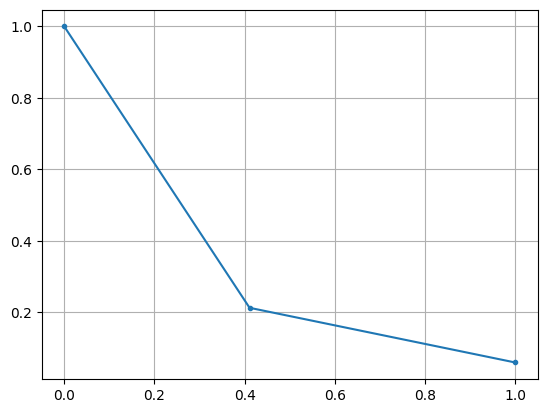

In [103]:
precision, recall, thresholds = precision_recall_curve(y_test_data, y_prediction)

plt.plot(recall, precision, marker='.')
f1 = 2* (precision * recall)/(precision + recall)
plt.grid(True)
print(f1)
plt.show()